<a href="https://colab.research.google.com/github/Wazhee/KAN-vs-MLP/blob/main/U_KAN_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is KAN?

## Kolmogorov-Arnold Networks
##### New class of neural networks aimed to be more less prone to overfitting and more interpretable than multi-layer perceptrons

##### In this experiment we see if KAN can truly outperform MLP in segmentation tasks. I conduct the following experiments:
- Train U-KAN (using KAN) and U-Net (using MLP) architectures on Brats2023 Brain MRI segmentation dataset
- Evaluate U-KAN and U-Net dice similarity performance
- Evaluate U-KAN and U-Nets sensitivity to sample size and number of epochs
- Evaluate U-KAN and U-Net computational load

<img src='https://drive.google.com/file/d/1uS2mrRleKRhyF_3An_qaalMLMvU5hFqZ/view?usp=drive_link' style="height:115px">

## Load U-KAN Repository

In [1]:
!git clone https://github.com/CUHK-AIM-Group/U-KAN.git

Cloning into 'U-KAN'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 193 (delta 21), reused 15 (delta 13), pack-reused 159 (from 1)
Receiving objects: 100% (193/193), 2.58 MiB | 9.38 MiB/s, done.
Resolving deltas: 100% (85/85), done.


# Install Dependencies

In [16]:
# Changing working directory
import os
from google.colab import drive
# os.chdir('U-KAN/Seg_UKAN/')
drive.mount("/content/drive")

# !pip install timm
# !pip install MedPy
# !pip install tensorboardX

Mounted at /content/drive


# Load Brats2020 Segmentation Dataset

- This code gets your BRATS dataset ready for semantic segmentation.

In [96]:
import numpy as np
from tqdm import tqdm
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

savepath = "brats2020/" # path to save images after preprocessing
if not os.path.exists(savepath):
  os.makedirs(savepath)

path = "/content/drive/MyDrive/Brats2020/"
TRAIN_DATASET_PATH = path
subject = os.listdir(path)[1]

path_to_images = os.path.join(path, subject)
images = os.listdir(path_to_images)
flair, t2, t1ce, t1, seg = "","","","",""
for i in images:
  if "flair" in i:
    flair = i
  if "t2" in i:
    t2 = i
  if "t1" in i:
    t1ce = i
  if "t1ce" in i:
    t1 = i
  if "seg" in i:
    seg = i

In [97]:
test_image_flair=nib.load(path_to_images+'/'+flair).get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape.
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)
test_image_t1=nib.load(path_to_images+'/'+t1).get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(path_to_images+'/'+t1ce).get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(path_to_images+'/'+t2).get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

1595.0


In [98]:
test_mask=nib.load(path_to_images+'/'+seg).get_fdata()
test_mask=test_mask.astype(np.uint8)

print("unique classes: ", np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print("unique classes: ", np.unique(test_mask))

unique classes:  [0 1 2 4]
unique classes:  [0 1 2 3]


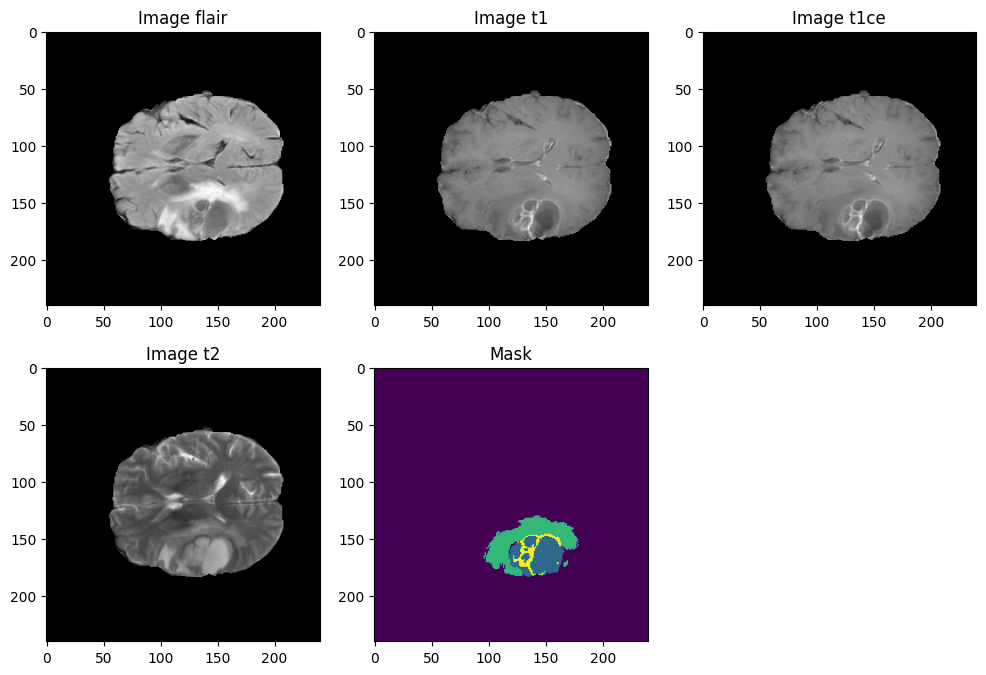

In [99]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

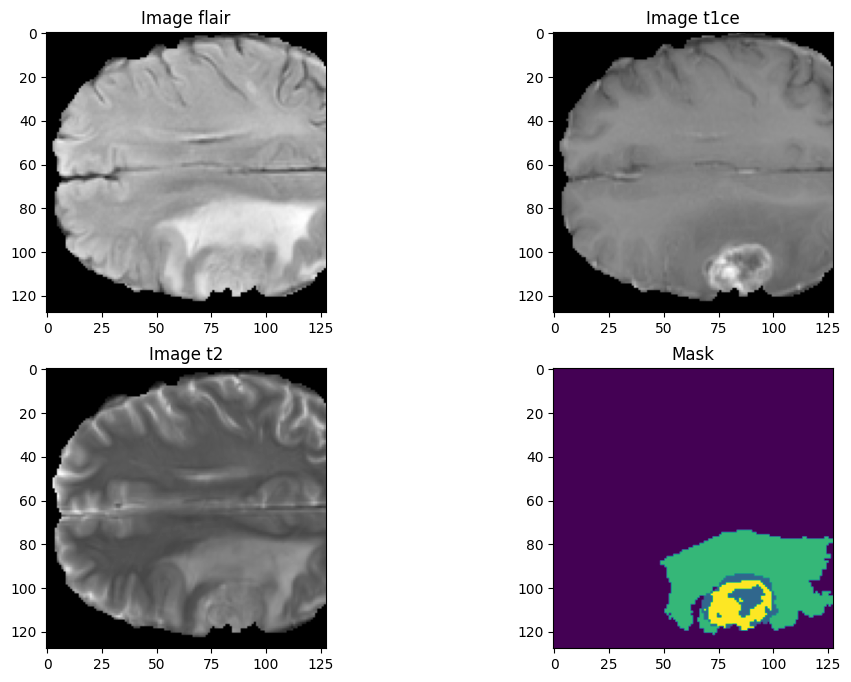

In [100]:
##################################################
#PART 2: Explore the process of combining images to channels and divide them to patches
#Includes...
#Combining all 4 images to 4 channels of a numpy array.
#
################################################
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches.
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [101]:
imsave(f'{savepath}combined255.tif', combined_x)
np.save(f'{savepath}combined255.npy', combined_x)
#Verify image is being read properly
#my_img=imread('BraTS2020_TrainingData/combined255.tif')

my_img=np.load(f'{savepath}combined255.npy')
test_mask = to_categorical(test_mask, num_classes=4)

<ipython-input-101-375b0b09d924>:1: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(f'{savepath}combined255.tif', combined_x)


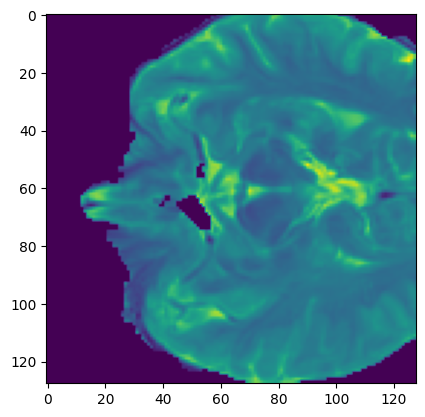

In [102]:
my_img=np.load(f'{savepath}combined255.npy')
plt.imshow(my_img[:,:,50,2])

In [103]:
#Now let us apply the same as above to all the images...
#Merge channels, crop, patchify, save
#GET DATA READY =  GENERATORS OR OTHERWISE

#Keras datagenerator does ntot support 3d

# # # images lists harley
#t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob(f'{TRAIN_DATASET_PATH}*/*t2.nii'))
t1ce_list = sorted(glob.glob(f'{TRAIN_DATASET_PATH}*/*t1ce.nii'))
flair_list = sorted(glob.glob(f'{TRAIN_DATASET_PATH}*/*flair.nii'))
mask_list = sorted(glob.glob(f'{TRAIN_DATASET_PATH}*/*seg.nii'))

In [104]:
import cv2
#Each volume generates 18 64x64x64x4 sub-volumes.
#Total 369 volumes = 6642 sub volumes
for img in tqdm(range(len(t2_list))):   #Using t1_list as all lists are of same size
    #print("Now preparing image and masks number: ", img)

    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))

    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches.
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        # print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)

        impath,maskpath = f'{savepath}images/',f'{savepath}masks/'
        if not os.path.exists(impath):
          os.makedirs(impath)
        if not os.path.exists(maskpath):
          os.makedirs(maskpath)

        cv2.imwrite(impath+str(img)+'.tif',temp_combined_images)
        cv2.imwrite(maskpath+str(img)+'.tif',temp_mask)

    else:
        print("I am useless")

  3%|▎         | 5/195 [00:39<25:31,  8.06s/it]

I am useless


 14%|█▍        | 28/195 [03:29<22:48,  8.20s/it]

I am useless


 18%|█▊        | 36/195 [04:46<22:24,  8.45s/it]

I am useless


 23%|██▎       | 44/195 [05:48<19:06,  7.59s/it]

I am useless


 31%|███▏      | 61/195 [09:00<18:07,  8.11s/it]

I am useless


 32%|███▏      | 63/195 [09:16<17:45,  8.07s/it]

I am useless


 41%|████      | 79/195 [11:27<15:30,  8.02s/it]

I am useless


 42%|████▏     | 82/195 [11:50<14:41,  7.80s/it]

I am useless


 44%|████▍     | 86/195 [12:23<14:23,  7.92s/it]

I am useless


 51%|█████     | 99/195 [14:12<12:37,  7.89s/it]

I am useless


 55%|█████▌    | 108/195 [15:26<11:18,  7.80s/it]

I am useless


 56%|█████▋    | 110/195 [15:44<11:45,  8.30s/it]

I am useless


 63%|██████▎   | 122/195 [17:29<11:28,  9.44s/it]

I am useless


 71%|███████▏  | 139/195 [19:48<07:31,  8.06s/it]

I am useless


 73%|███████▎  | 142/195 [20:11<06:46,  7.67s/it]

I am useless


 91%|█████████ | 177/195 [24:35<02:01,  6.76s/it]

I am useless


100%|██████████| 195/195 [26:58<00:00,  8.30s/it]


In [112]:
from PIL import Image

img = Image.open("/content/U-KAN/Seg_UKAN/brats2020/images/0.tif")
img
# print(np.array(img).shape)

UnidentifiedImageError: cannot identify image file '/content/U-KAN/Seg_UKAN/brats2020/images/0.tif'

# U-KAN training

In [109]:
#!python train.py --arch UKAN --dataset {dataset} --input_w {input_size} --input_h {input_size} --name {dataset}_UKAN  --data_dir [YOUR_DATA_DIR]
!python train.py --arch UKAN --dataset /content/U-KAN/Seg_UKAN/brats2020 --input_w 128 --input_h 128 --name brats_UKAN  --data_dir Results

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
--------------------
name: brats_UKAN
epochs: 400
batch_size: 8
dataseed: 2981
arch: UKAN
deep_supervision: False
input_channels: 3
num_classes: 1
input_w: 128
input_h: 128
input_list: [128, 160, 256]
loss: BCEDiceLoss
dataset: /content/U-KAN/Seg_UKAN/brats2020
data_dir: Results
output_dir: outputs
optimizer: Adam
lr: 0.0001
momentum: 0.9
weight_decay: 0.0001
nesterov: False
kan_lr: 0.01
kan_weight_decay: 0.0001
scheduler: CosineAnnealingLR
min_lr: 1e-05
factor: 0.1
patience: 2
milestones: 1,2
gamma: 0.6666666666666666
early_stopping: -1
cfg: None
num_workers: 4
no_kan: False
--------------------
/content/U-KAN/Seg_UKAN/train.py:340: DeprecationWarning: Flip is deprecated